In [1]:
from Supporting_functions import *

import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
import skimage 
import RedLionfishDeconv as rl

In [2]:
def image_preprocessing(img, mask, percentiles, min_v, max_v):
    
    # Image Normalization
    if percentiles[0] > 0 or percentiles[1] < 100:
        low_thres, high_thres0 = getNormalizationThresholds(img, percentiles) # low thres in whole image
        low_thres0, high_thres = getNormalizationThresholds(img * mask, percentiles) # high thres in FG
        img = remove_outliers_image(img, low_thres, high_thres)
  
    img = image_scaling(img, min_v, max_v, True)
    img = img.astype(np.uint16)
    
    return img

# Predictions for different models


In [8]:
# Define paths
# Copy all deblur model in folder deblur (manually)

modelName = 'Enhance_NucleiMembranes'

# Models
srcpath = r'/media/hmorales/Skynet/IsoNet/Models/'+modelName+'/'
path_models = srcpath+'checkpoint/saved_models/deblur/'
psf_path = r'/home/hmorales/WorkSpace/DataIsoReconstructions/Averaged_transformed_PSF_488.tif'

# Image to test
img_src_path = '/media/hmorales/Skynet/IsoNet/SourceData/Nuclei_Membrane_20230929_original/'
imgName = 'spim20230929_TL050_Channel0_Angle0'
img_test_path = os.path.join(img_src_path, imgName+'.tif')


#output dri
outdir = img_src_path+'/res_'+modelName+'/'
outsufix = 'Self_Net_output_'+modelName

# CUDA device
device1 = torch.device('cuda:0')
device2 = torch.device('cuda:0')
batch_size = 64

# Image Normalization
min_v = 0
max_v = 65535

thres_scale = 1.5  # threhold for simple mask for normalization
norm_percentiles = (20, 99.999)

# deconvolution
padding = 32
Niter = 20

# Create output folder
if not os.path.exists(outdir):
    os.mkdir(outdir)

     -threshold_value: 370.5
Intensity Norm  from (0 , 8322) to  (0, 65535)  

Intensity Norm  from (0 , 20060) to  (0, 65535)  

(160, 250, 250)
(160, 250, 250)
(250, 160, 250)
(250, 160, 250)


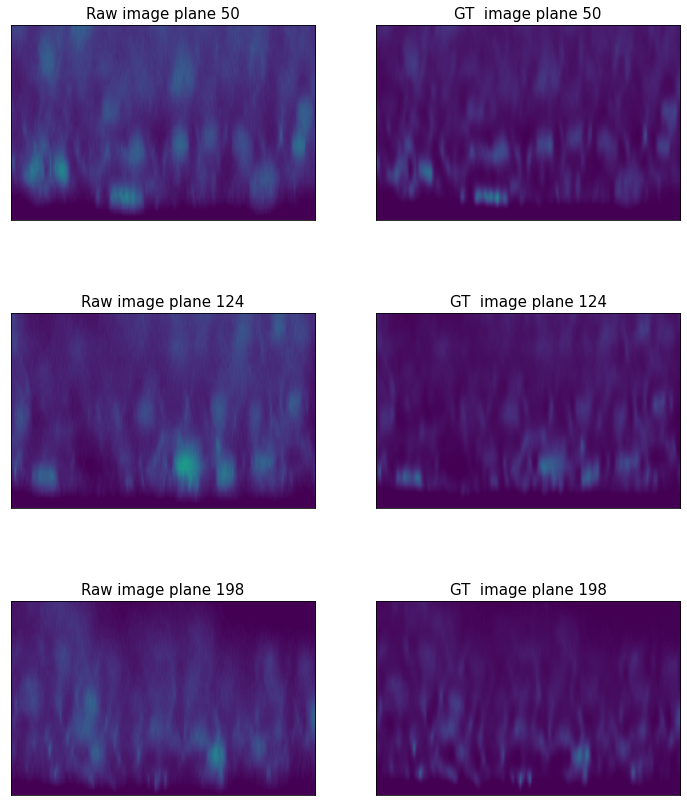

In [9]:
# Open PSF and Prepare PSF
psf = tifffile.imread(psf_path)
psf_f = psf.astype(np.float32)
psf_norm = psf_f/psf_f.sum()

# Load images
raw_img  =  tifffile.imread(img_test_path).astype(np.float32)

[physical_pixel_sizeX,physical_pixel_sizeY,physical_pixel_sizeZ] = read_tiff_voxel_size(img_test_path)    
scale = physical_pixel_sizeX / physical_pixel_sizeZ
    
mask = get_image_simple_mask(raw_img, 0, 1.0, thres_scale)  
mask =  mask.astype(np.int16)
    
# generate GT
img = np.pad(raw_img, padding, mode='reflect')
# GPU deconvolution
gt_img = rl.doRLDeconvolutionFromNpArrays(img, psf, niter=Niter,resAsUint8=False)
gt_img = gt_img[padding:-padding, padding:-padding, padding:-padding]
gt_img   =  gt_img.astype(np.float32)

# process


raw_img = image_preprocessing(raw_img, mask, norm_percentiles, min_v, max_v)
gt_img  = image_preprocessing(gt_img, mask, norm_percentiles,  min_v, max_v)


raw_img = raw_img[:,125:375,125:375]
gt_img  = gt_img[:,125:375,125:375]
mask  = mask[:,125:375,125:375]

print(raw_img.shape)
print(gt_img.shape)

outName = os.path.join(img_src_path, imgName+'crop.tif')
tifffile.imwrite(outName,raw_img)
outName = os.path.join(img_src_path, imgName+'crop_gt.tif')
tifffile.imwrite(outName,gt_img)


# plot some axial planes

if abs(1.0-scale) > 1e-3: 
    raw_img_xz  =reslice(raw_img,'xz',physical_pixel_sizeX, physical_pixel_sizeZ)
else:
    raw_img_xz = np.transpose(raw_img,[1,0,2])

gt_img_xz  = np.transpose(gt_img,[1,0,2])

print(raw_img_xz.shape)
print(gt_img_xz.shape)


def show(ax, image, title):
    ax.imshow(image, cmap='viridis', vmin=0, vmax=65535)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(title,fontsize=15)
    
fig = plt.figure(figsize=(12,15))
axs = fig.subplots(3,2)
dplane = int(0.2*raw_img_xz.shape[0])

for i, idx in enumerate(range(dplane,raw_img_xz.shape[0], int(0.5*(raw_img_xz.shape[0]-2*dplane))-1)):   
    subtitle0 = f"Raw image plane {idx}" 
    subtitle1 = f"GT  image plane {idx}" 
    show(axs[i,0], raw_img_xz[idx,:,:], subtitle0)
    show(axs[i,1], gt_img_xz[idx,:,:], subtitle1)    


In [5]:
# Prepare networks
deblur_net_A = Self_net_architecture.define_G(input_nc=1, output_nc=1, ngf=64, netG='deblur_net', device=device1,use_dropout=False,norm='instance')
deblur_net_B = Self_net_architecture.define_G(input_nc=1, output_nc=1, ngf=64, netG='deblur_net', device=device1,use_dropout=False,norm='instance')


# Get all models ('pkl' files) in the folder
model_names = [f for f in os.listdir(path_models) if f.endswith('.pkl')]
model_names.sort(key=custom_sort)

# Calculate for each model
for i, model_name in enumerate(model_names):

#    start_time = time.time()  # Record the start time    
    img = raw_img
    model_path = os.path.join(path_models,model_name);
    # Load Model
    deblur_net_A.load_state_dict(torch.load(model_path))
    deblur_net_B.load_state_dict(torch.load(model_path))
    # Predict image
    fusion_stack=upsample_block(img,physical_pixel_sizeX, physical_pixel_sizeZ, deblur_net_A,deblur_net_B,min_v,max_v, device1, device2, batch_size)
    
    fusion_stack  = image_preprocessing(fusion_stack, mask, norm_percentiles, min_v, max_v)
    #newimg_min = np.amin(fusion_stack)
    #newimg_max = np.amax(fusion_stack)	
    #print('fusion_stack  (%d, %d) ' % (newimg_min, newimg_max), '\n')
    
    # Save result
    outName = outdir+'Self_Net_output'+model_name+'.tif';
    tifffile.imwrite(outName,fusion_stack)
    
#    elapsed_time = time.time() - start_time
#    print(f"Elapsed Time: {elapsed_time:.4f} seconds, model{model_name}")


initialize network with normal
initialize network with normal



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


Intensity Norm  from (0 , 42015) to  (0, 65535)  




100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.74it/s]


Intensity Norm  from (0 , 56673) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.73it/s]


Intensity Norm  from (0 , 59326) to  (0, 65534)  




100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.73it/s]


Intensity Norm  from (0 , 59632) to  (0, 65534)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.08it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.73it/s]


Intensity Norm  from (0 , 60650) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.08it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.73it/s]


Intensity Norm  from (0 , 60592) to  (0, 65534)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.08it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.73it/s]


Intensity Norm  from (0 , 60173) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.08it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.73it/s]


Intensity Norm  from (0 , 59741) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 57516) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.01it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.68it/s]


Intensity Norm  from (0 , 54201) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Intensity Norm  from (0 , 56215) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]


Intensity Norm  from (0 , 55045) to  (0, 65534)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]


Intensity Norm  from (0 , 53400) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.01it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.68it/s]


Intensity Norm  from (0 , 56017) to  (0, 65535)  




100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.62it/s]


Intensity Norm  from (0 , 55789) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 55612) to  (0, 65535)  




100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 57268) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]


Intensity Norm  from (0 , 58527) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.73it/s]


Intensity Norm  from (0 , 58495) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Intensity Norm  from (0 , 57679) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.01it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.67it/s]


Intensity Norm  from (0 , 57026) to  (0, 65534)  




100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.59it/s]


Intensity Norm  from (0 , 57229) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.98it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.66it/s]


Intensity Norm  from (0 , 58242) to  (0, 65534)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.92it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.61it/s]


Intensity Norm  from (0 , 58250) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.01it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.68it/s]


Intensity Norm  from (0 , 56352) to  (0, 65534)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]


Intensity Norm  from (0 , 56829) to  (0, 65535)  




100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.69it/s]


Intensity Norm  from (0 , 58687) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.01it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.67it/s]


Intensity Norm  from (0 , 57337) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.99it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.67it/s]


Intensity Norm  from (0 , 55219) to  (0, 65535)  




100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 55275) to  (0, 65534)  




100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]


Intensity Norm  from (0 , 57060) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 54344) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Intensity Norm  from (0 , 56667) to  (0, 65535)  




100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 55670) to  (0, 65535)  




100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 53559) to  (0, 65535)  




100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 56953) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 52455) to  (0, 65535)  




100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]


Intensity Norm  from (0 , 51678) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 54310) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Intensity Norm  from (0 , 49739) to  (0, 65535)  




100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Intensity Norm  from (0 , 56115) to  (0, 65535)  




100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 55301) to  (0, 65534)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 57290) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Intensity Norm  from (0 , 51201) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Intensity Norm  from (0 , 57044) to  (0, 65534)  




100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 47510) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 58208) to  (0, 65535)  




100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Intensity Norm  from (0 , 56859) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 54241) to  (0, 65535)  




100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Intensity Norm  from (0 , 58749) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 58740) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Intensity Norm  from (0 , 60253) to  (0, 65534)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Intensity Norm  from (0 , 59361) to  (0, 65535)  




100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 51724) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 53446) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 54796) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 57605) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 60086) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Intensity Norm  from (0 , 56595) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 59085) to  (0, 65534)  




100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 60732) to  (0, 65534)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 55549) to  (0, 65534)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 58821) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 55330) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Intensity Norm  from (0 , 59149) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Intensity Norm  from (0 , 55122) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 57565) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Intensity Norm  from (0 , 59378) to  (0, 65535)  




100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 55925) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Intensity Norm  from (0 , 52984) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 60029) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.69it/s]


Intensity Norm  from (0 , 60417) to  (0, 65535)  




100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.69it/s]


Intensity Norm  from (0 , 55026) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]


Intensity Norm  from (0 , 61233) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.69it/s]


Intensity Norm  from (0 , 58808) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]


Intensity Norm  from (0 , 57597) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]


Intensity Norm  from (0 , 54572) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]


Intensity Norm  from (0 , 60597) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]


Intensity Norm  from (0 , 58580) to  (0, 65534)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]


Intensity Norm  from (0 , 61214) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]


Intensity Norm  from (0 , 56523) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.69it/s]


Intensity Norm  from (0 , 60309) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]


Intensity Norm  from (0 , 60288) to  (0, 65534)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.52it/s]


Intensity Norm  from (0 , 60273) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]


Intensity Norm  from (0 , 54815) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.69it/s]


Intensity Norm  from (0 , 56710) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.69it/s]


Intensity Norm  from (0 , 60504) to  (0, 65535)  




100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.69it/s]


Intensity Norm  from (0 , 60828) to  (0, 65534)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]


Intensity Norm  from (0 , 56498) to  (0, 65534)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.69it/s]


Intensity Norm  from (0 , 56499) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]


Intensity Norm  from (0 , 59654) to  (0, 65534)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]


Intensity Norm  from (0 , 60839) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 59040) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Intensity Norm  from (0 , 56606) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 61253) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 57154) to  (0, 65534)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Intensity Norm  from (0 , 57322) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Intensity Norm  from (0 , 61149) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Intensity Norm  from (0 , 56584) to  (0, 65534)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 53416) to  (0, 65535)  



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Intensity Norm  from (0 , 62132) to  (0, 65535)  




100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Intensity Norm  from (0 , 59946) to  (0, 65535)  




100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Intensity Norm  from (0 , 60090) to  (0, 65535)  



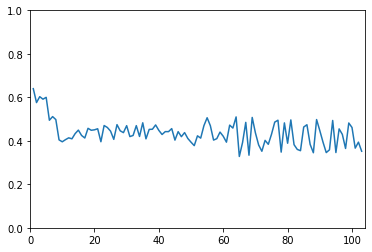

In [10]:
from skimage import io
from skimage.metrics import structural_similarity as ssim

model_names = [f for f in os.listdir(path_models) if f.endswith('.pkl')]
model_names.sort(key=custom_sort)

# get stats of predictions and GT

Nmodels= len(model_names)
model_idx = np.linspace(1,Nmodels,Nmodels)


# crop image GT and reference

#ref_img = raw_img_intep[:,:,:]
gt_scaled_img  = gt_img#[:,:,:]



# SSIM

y = np.empty_like(model_idx)
y[:] = np.nan


fig, ax = plt.subplots()
line, = ax.plot(model_idx, y) 
ax.set_xlim(0, Nmodels+1)
ax.set_ylim(0.0, 1.0)


# Calculate for each model
for idx, model_name in enumerate(model_names):
    # open result
    outName = outdir+'Self_Net_output'+model_name+'.tif';
    res_img  =  tifffile.imread(outName).astype(np.float32)   
    #res_img = res_img[:,:,:]
   
    # Get anisotopy
    ssim_value = ssim(gt_scaled_img, res_img, gaussian_weights=True) 
    print(ssim_value)
    
    #eigen_pred = skimage.measure.inertia_tensor_eigvals(res_img)
    #a_pred = eigen_pred[2]/eigen_pred[0]

  
    y[idx] = ssim_value
    #yGT[idx] = a_GT
    
    # Update the plot
    line.set_ydata(y)
    #lineGT.set_ydata(yGT)
    clear_output(wait=True)  # Clear the previous plot
    display(fig)
    
    # Close the figure when the loop is done
    plt.close(fig)
    #print(a_pred)
    

In [7]:
# Get max simm

max_value = np.max(y)
max_index = np.argmax(y)+1

print("Maximum Value:", max_value)
print("Index of Maximum Value:", max_index)
print("Model Maximum Value:", model_names[max_index])

outName = img_src_path+outsufix+'_gt.tif';
tifffile.imwrite(outName,gt_img)

outName = img_src_path+outsufix+'_raw.tif';
tifffile.imwrite(outName,raw_img)

outName = outdir+'Self_Net_output'+model_names[max_index]+'.tif';   
res_img  =  tifffile.imread(outName).astype(np.float32)   
res_img = res_img#[35:100,:,:]
outName = img_src_path+outsufix+'_pred_'+model_names[max_index]+'.tif';
tifffile.imwrite(outName,res_img)


Maximum Value: 0.6820962345821302
Index of Maximum Value: 1
Model Maximum Value: deblur_net_1_16000.pkl
